# Primary Production Lab - Version 3
**Developed for the OOI Data Lab Notebook**

By Sage Lichtenwalner

Revised April 18, 2020.  Updated August 11, 2020 to improve outlier handling. 

In [ ]:
# Notebook setup
import requests
import os
import re
import xarray as xr
!pip install netcdf4
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make the Plots pretty
import seaborn as sns
sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Request Data from OOINet

* **Instruments:** 
  * CP04OSSM-RID27-02-FLORTD000 (Chlorophyll-a, Temperature, and Salinity) from the Coastal Pioneer Offshore Surface Mooring
  * CP01CNSM-RID26-07-NUTNRB000 (Nitrate) from the Coastal Pioneer Central Surface Mooring
  * CP03ISSM-SBD11-06-METBKA000 (Shortwave Irradiance) from the Coastal Pioneer Inshore Surface Mooring
* **Time range:** 
  * Four years of data: 2016-01-01 00:00:00 to 2020-01-01 00:00:00


In [ ]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [ ]:
API_USERNAME = ''
API_TOKEN = ''

In [ ]:
# Data Requests - Telemetered
# request_data('CP04OSSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP01CNSM-RID26-07-NUTNRB000','telemetered','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

# Recovered (could be used once fall 2019 deployments are added, though flort has a gap)
# request_data('CP04OSSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP01CNSM-RID26-07-NUTNRB000','recovered_inst','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

## 2. Load Data Files

In [ ]:
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043545772Z-CP04OSSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nutnr = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043607428Z-CP01CNSM-RID26-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'
url_metbk = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043625447Z-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'


In [ ]:
def get_datalist(url):
  '''Return all the relevant .nc files from a specified OOI THREDDS url'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous data files if necessary
  catalog_rms = url.split('/')[-2][20:]
  selected_datasets = []
  for d in datasets:
    if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
      selected_datasets.append(d + '#fillmismatch') # Add #fillmismatch to the URL to deal with a bug
  selected_datasets = sorted(selected_datasets)
  return selected_datasets

In [ ]:
# List of data files
flort_files = get_datalist(url_flort)
nutnr_files = get_datalist(url_nutnr)
metbk_files = get_datalist(url_metbk)

In [ ]:
%%time
# Load the data files using xarray
data_flort = xr.open_mfdataset(flort_files).swap_dims({'obs': 'time'})
print('FLORT dataset has %s points' % "{:,}".format(data_flort.time.size))

FLORT dataset has 17,309,314 points
CPU times: user 4.35 s, sys: 698 ms, total: 5.04 s
Wall time: 1min 51s


In [ ]:
%%time
data_nutnr = xr.open_mfdataset(nutnr_files).swap_dims({'obs': 'time'})
print('NUTNR dataset has %s points' % "{:,}".format(data_nutnr.time.size))


NUTNR dataset has 440,216 points
CPU times: user 19.7 s, sys: 3.96 s, total: 23.7 s
Wall time: 17min 8s


In [ ]:
%%time
data_metbk = xr.open_mfdataset(metbk_files).swap_dims({'obs': 'time'})
print('METBK dataset has %s points' % "{:,}".format(data_metbk.time.size))

METBK dataset has 1,992,731 points
CPU times: user 1.31 s, sys: 230 ms, total: 1.54 s
Wall time: 1min 9s


In [ ]:
%%time
# Convert to Pandas
data_flort2 = data_flort[['practical_salinity','temp','fluorometric_chlorophyll_a']].to_dataframe()
data_nutnr = data_nutnr[['salinity_corrected_nitrate']].to_dataframe()
data_metbk = data_metbk[['longwave_irradiance','shortwave_irradiance']].to_dataframe()

CPU times: user 14.6 s, sys: 3.65 s, total: 18.3 s
Wall time: 12min 44s


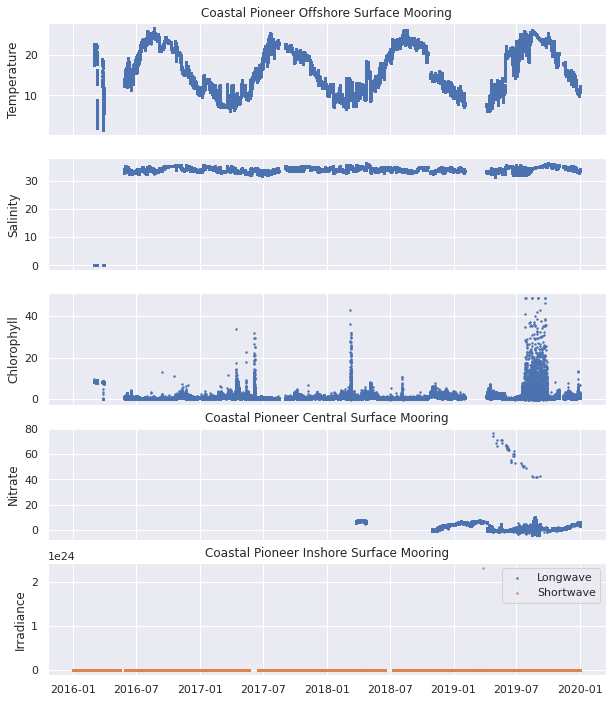

In [ ]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(data_flort2.index, data_flort2.temp, s=2)
ax2.scatter(data_flort2.index, data_flort2.practical_salinity, s=2)
ax3.scatter(data_flort2.index, data_flort2.fluorometric_chlorophyll_a, s=2)
ax4.scatter(data_nutnr.index, data_nutnr.salinity_corrected_nitrate, s=2)
ax5.scatter(data_metbk.index, data_metbk.longwave_irradiance, label='Longwave', s=2)
ax5.scatter(data_metbk.index, data_metbk.shortwave_irradiance, label='Shortwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production1.png');

## 3. Remove Outliers

In [ ]:
import numpy as np
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

def clean_data(data,min=0,max=100):
  data = data.where((data>min) & (data<max))
  data = data.where(reject_outliers(data))
  return data


In [ ]:
# Remove Outliers
data_flort2['practical_salinity'] = clean_data(data_flort2['practical_salinity'],30,40)
data_flort2['fluorometric_chlorophyll_a'] = clean_data(data_flort2['fluorometric_chlorophyll_a'],0,50)
data_nutnr['salinity_corrected_nitrate'] = clean_data(data_nutnr['salinity_corrected_nitrate'],0,40)
data_metbk['shortwave_irradiance'] = clean_data(data_metbk['shortwave_irradiance'],0,1000)
data_metbk['shortwave_irradiance'] = clean_data(data_metbk['shortwave_irradiance'],0,1000) #Run again

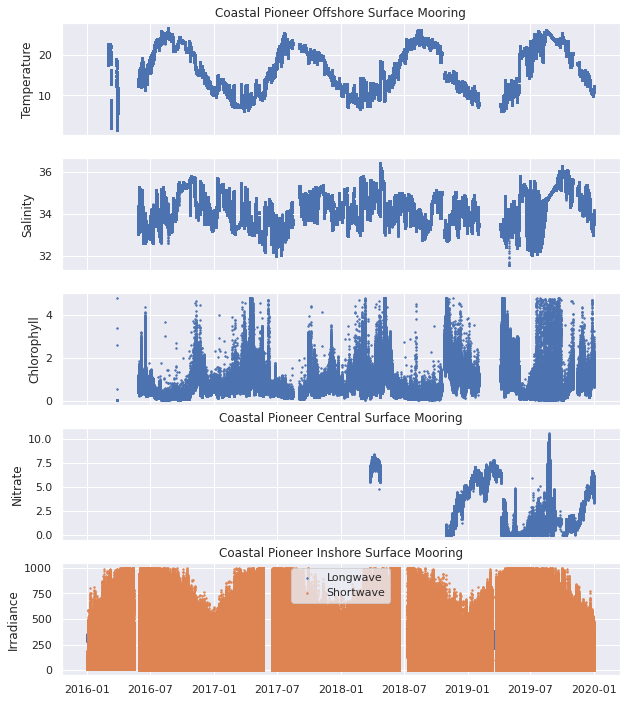

In [ ]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(data_flort2.index, data_flort2.temp, s=2)
ax2.scatter(data_flort2.index, data_flort2.practical_salinity, s=2)
ax3.scatter(data_flort2.index, data_flort2.fluorometric_chlorophyll_a, s=2)
ax4.scatter(data_nutnr.index, data_nutnr.salinity_corrected_nitrate, s=2)
ax5.scatter(data_metbk.index, data_metbk.longwave_irradiance, label='Longwave', s=2)
ax5.scatter(data_metbk.index, data_metbk.shortwave_irradiance, label='Shortwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production2.png');

## 4. Average & Merge

In [ ]:
data_flort2 = data_flort2.resample('1D').mean()
data_nutnr = data_nutnr.resample('1D').mean()
data_metbk = data_metbk.resample('1D').mean()

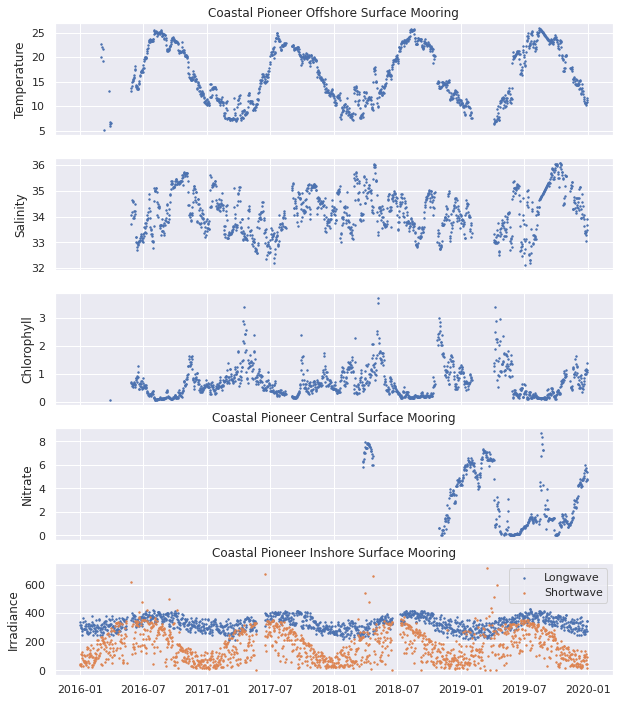

In [ ]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
ax1.scatter(data_flort2.index, data_flort2.temp, s=2)
ax2.scatter(data_flort2.index, data_flort2.practical_salinity, s=2)
ax3.scatter(data_flort2.index, data_flort2.fluorometric_chlorophyll_a, s=2)
ax4.scatter(data_nutnr.index, data_nutnr.salinity_corrected_nitrate, s=2)
ax5.scatter(data_metbk.index, data_metbk.longwave_irradiance, label='Longwave', s=2)
ax5.scatter(data_metbk.index, data_metbk.shortwave_irradiance, label='Shortwave', s=2)
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('production3.png');

## 5. Merge and Export

In [ ]:
# data_flort2 = data_flort2.drop('obs',axis=1)
# data_nutnr = data_nutnr.drop('obs',axis=1)
# data_metbk = data_metbk.drop('obs',axis=1)

data = data_flort2.merge(data_nutnr,on='time',how='outer').merge(data_metbk,on='time',how='outer')
data.head()

,practical_salinity,temp,fluorometric_chlorophyll_a,salinity_corrected_nitrate,longwave_irradiance,shortwave_irradiance
time,,,,,,
2016-03-01,NaN,22.685326,NaN,NaN,271.030090,235.723206
2016-03-02,NaN,20.129663,NaN,NaN,319.400146,41.020458
2016-03-03,NaN,NaN,NaN,NaN,250.614105,234.590515
2016-03-04,NaN,22.152140,NaN,NaN,322.843445,38.382534
2016-03-05,NaN,NaN,NaN,NaN,287.744629,211.891083


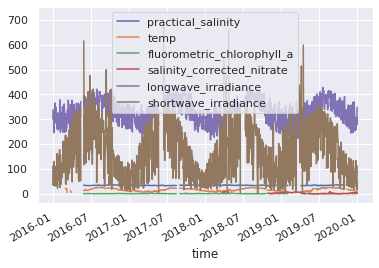

In [ ]:
# Quickplot
data.plot();

In [ ]:
# Export to CSV
data.to_csv('production.csv')